In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import numpy as np
from sklearn.model_selection import train_test_split
import re
import spacy
import nltk, warnings
nltk.download('punkt')
from readability import Readability

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [4]:
df = pd.read_csv("../data/df_with_features.csv")

In [5]:
def select_equal_groups(group: pd.core.groupby.generic.DataFrameGroupBy, n: int):

    return group.sample(min(n, len(group)), random_state=42)

share_train = 0.7
share_test = 0.3
samples_train = int(len(df)*(share_train*(1-share_test)))
samples_per_group = int(samples_train/5)

df['ID'] = range(0, len(df))
df_abstract_intro = df[~df['Type'].str.contains("conclusion_chunked")]
df_train= df_abstract_intro.groupby("Author", group_keys=False)\
        .apply(select_equal_groups, samples_per_group)\
        .reset_index(drop=True)

df_test_val = df[~df['ID'].isin(df_train['ID'])]
df_val = df_test_val[~df_test_val['Type'].str.contains("conclusion_chunked")]
df_val, df_test_0  = train_test_split(df_val, train_size = 0.5, stratify = df_val['Author'], random_state = 42)
df_test_1 = df_test_val[df_test_val['Type'].str.contains("conclusion_chunked")]

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


# 3. Split Data

In [6]:
#punctuation n-grams
punct_vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, use_idf=False, norm='l1', vocabulary=string.punctuation)

In [7]:
pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4))

In [8]:
stopword_vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=nltk.word_tokenize, vocabulary=stopwords.words("english"))

In [9]:
word_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# 4. Tokenize Datasets

In [10]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
def clean_punct(test_str):
    for ele in test_str:
        if ele in punc:
            test_str = test_str.replace(ele, "")
    return test_str

In [11]:
def remove_stopwords(example_text):
    word_tokens = word_tokenize(example_text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stopwords.words("english")]
    return " ".join(filtered_sentence)

In [12]:
def preprocess_data(df, text_col, train = False):
    df = df.reset_index(drop = True)
    #these should be run first before cleaning punctuation and private words and stuff
    #df['flesch_score'] = df[text_col].apply(flesch_readability_scale)
    #commented out for now as takes long to run
    try:
        punct_features = punct_vectorizer.fit_transform(df[text_col]) if train else punct_vectorizer.transform(df[text_col])
        columns = [f'punct_{c}' for c in punct_vectorizer.get_feature_names_out()]
        punct_features_df = pd.DataFrame(punct_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, punct_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Punctuation N-grams: {e}")
    try:
        POS_features = pos_vectorizer.fit_transform(df['POS_string']) if train else pos_vectorizer.transform(df['POS_string'])
        columns = [f'pos_{c}' for c in pos_vectorizer.get_feature_names_out()]
        POS_features_df = pd.DataFrame(POS_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, POS_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating POS N-grams: {e}")

    #lowercase everything
    df[text_col] = df[text_col].apply(str.lower)
    df[text_col] = df[text_col].apply(clean_punct)

    try:
        stopwords_features = stopword_vectorizer.fit_transform(df[text_col]) if train else stopword_vectorizer.transform(df[text_col])
        columns = [f'stop_{c}' for c in stopword_vectorizer.get_feature_names_out()]
        stopwords_features_df = pd.DataFrame(stopwords_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, stopwords_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Stopword N-grams: {e}")

    #remove stopwords here
    df[text_col] = df[text_col].apply(remove_stopwords)
    try:
        words_features = word_vectorizer.fit_transform(df[text_col]) if train else word_vectorizer.transform(df[text_col])
        columns = [f'word_{c}' for c in word_vectorizer.get_feature_names_out()]
        words_features_df = pd.DataFrame(words_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, words_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Word N-grams: {e}")
    return df

In [13]:
df_train_processed = preprocess_data(df_train, 're_text', train = True)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
df_val_processed = preprocess_data(df_val, 're_text', train = False)

In [15]:
df_test_0_processed = preprocess_data(df_test_0, 're_text', train = False)

In [16]:
df_test_1_processed = preprocess_data(df_test_1, 're_text', train = False)

In [17]:
# df_val_processed.to_pickle("./df_val_processed.pkl")
# df_test_0_processed.to_pickle("./df_test_0_processed.pkl")
# df_test_1_processed.to_pickle("./df_test_1_processed.pkl")

In [18]:
X_train_df = df_train_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "word_count", "sent_count", "sybl_count", "Unnamed: 0.1"])
colnames_reg = X_train_df.columns
y_train = df_train_processed['Author']

X_val_df = df_val_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "word_count", "sent_count", "sybl_count", "Unnamed: 0.1"])
y_val = df_val_processed['Author']

X_test_0_df = df_test_0_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "word_count", "sent_count", "sybl_count", "Unnamed: 0.1"])
y_test_0 = df_test_0_processed['Author']

X_test_1_df = df_test_1_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "word_count", "sent_count", "sybl_count", "Unnamed: 0.1"])
y_test_1 = df_test_1_processed['Author']

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.transform(X_val_df)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprec

In [20]:
X_test_0_scaled = scaler.transform(X_test_0_df)
X_test_1_scaled = scaler.transform(X_test_1_df)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprec

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


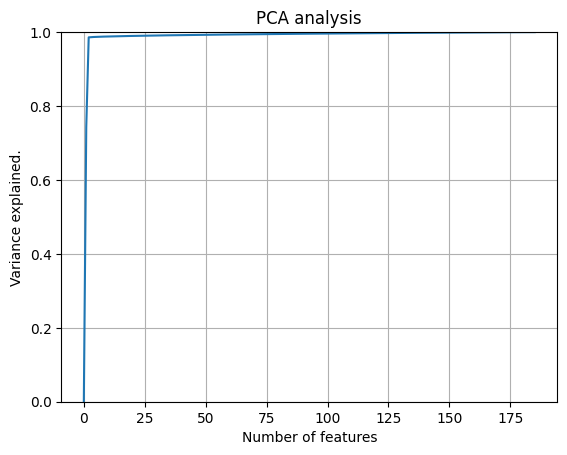

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

feature_names = colnames_reg.values.tolist()

pca = PCA(n_components=min(len(feature_names), len(X_train_df.index)))
pca.fit_transform(X_train_df)
fig, ax = plt.subplots()
ax.set_ylim([0, 1])
var_explained = pca.explained_variance_ratio_.cumsum()
var_explained = np.insert(var_explained, 0, 0)

components = list(range(len(var_explained)))
ax.plot(components, var_explained)
ax.set(xlabel='Number of features', ylabel='Variance explained.',
       title='PCA analysis')
ax.grid()

fig.savefig("pca_analysis.png")
plt.show()

In [38]:
# Keep only the first 25 components.
pca = PCA(n_components=25, random_state = 42)
X_train_pca = pca.fit_transform(X_train_df)
X_val_pca = pca.transform(X_val_df)
X_test_0_pca = pca.transform(X_test_0_df)
X_test_1_pca = pca.transform(X_test_1_df)


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprec

In [39]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [40]:
X_test_scaled = np.concatenate((X_val_scaled, X_test_0_scaled))
X_test_pca = np.concatenate((X_val_pca, X_test_0_pca))
y_test = np.concatenate((y_val, y_test_0))

In [41]:
def run_classifier(X_val, X_test, model):
    # Make predictions on the test set
    #model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_1 = model.predict(X_test)
    # Evaluate the accuracy of the model
    return y_pred, y_pred_1

In [42]:
#1. SVC
SVC_model = SVC(kernel = "linear", C = 0.5, random_state = 42)
SVC_model.fit(X_train_scaled, y_train)
predictions_SVC, predictions_SVC_conclusion = run_classifier(X_test_scaled, X_test_1_scaled, SVC_model)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [43]:
LR_model = LogisticRegression(penalty = "l2", solver = "saga", random_state = 42)
LR_model.fit(X_train_scaled, y_train)
predictions_LR, predictions_LR_conclusion = run_classifier(X_test_scaled, X_test_1_scaled, LR_model)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [44]:
RF_model = RandomForestClassifier(criterion = 'gini', n_estimators = 500, random_state = 42)
RF_model.fit(X_train_scaled, y_train)
predictions_RF, predictions_RF_conclusion = run_classifier(X_test_scaled, X_test_1_scaled, RF_model)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [45]:
df_test_final = pd.concat([df_val, df_test_0])
df_test_final = df_test_final.reset_index(drop = True)
df_test_final['prediction_SVC'] = predictions_SVC
df_test_final['prediction_RF'] = predictions_RF
df_test_final['prediction_LR'] = predictions_LR

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score, precision_score

default_metrics = {
    'accuracy': accuracy_score,
    'recall': lambda y_t, y_p: recall_score(y_t, y_p, zero_division="warn", average='micro'),
    'precision': lambda y_t, y_p: precision_score(y_t, y_p, zero_division="warn", average='micro'),
    'f1': lambda y_t, y_p: f1_score(y_t, y_p, zero_division= "warn", average ='macro')
}

mapping_authors = {'Aman Madaan': 1, 'Hugo Touvron': 2, 'Timo Schick': 3, 'Zhiqing Sun': 4,'GPT-3.5': 5}
def plot_accuracy(df, column, metrics):
    y_true = df['Author'].map(mapping_authors)
    y_pred = df[column].map(mapping_authors)

    # Remove labels and display_labels not present in y_true
    labels = [1, 2, 3, 4, 5]
    display_labels = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'GPT-3.5']

    # Plot count confusion matrix
    cm_disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=labels, display_labels=display_labels)

    # Show plot
    plt.show()

    # Calculate metrics
    metrics = {metric_name: metric_func(y_true, y_pred) for metric_name, metric_func in metrics.items()}
    print(metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

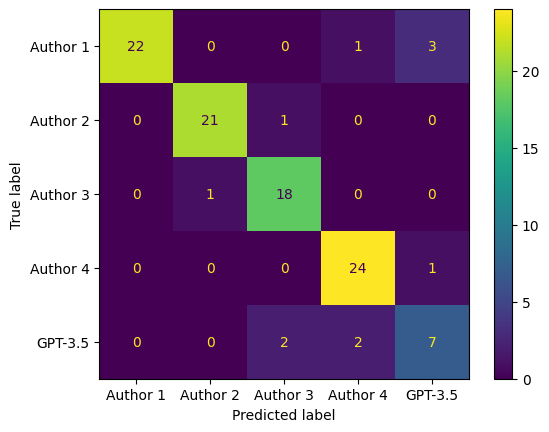

{'accuracy': 0.8932038834951457, 'recall': 0.8932038834951457, 'precision': 0.8932038834951457, 'f1': 0.8661305361305361}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [47]:
plot_accuracy(df_test_final, 'prediction_LR', default_metrics)

In [32]:
import eli5

In [33]:
colnames_reg_list = colnames_reg.tolist()

In [80]:
def top_and_bottom_indices(coef_matrix, top_n=10):
   
    top_indices = np.argsort(coef_matrix, axis=1)[-top_n:][::-1]
    bottom_indices = np.argsort(coef_matrix, axis=1)[:top_n]

    return top_indices, bottom_indices

In [91]:
SVC_model.coef_.shape

(10, 42855)

In [48]:
eli5.show_weights(LR_model, feature_names = colnames_reg_list)

42855


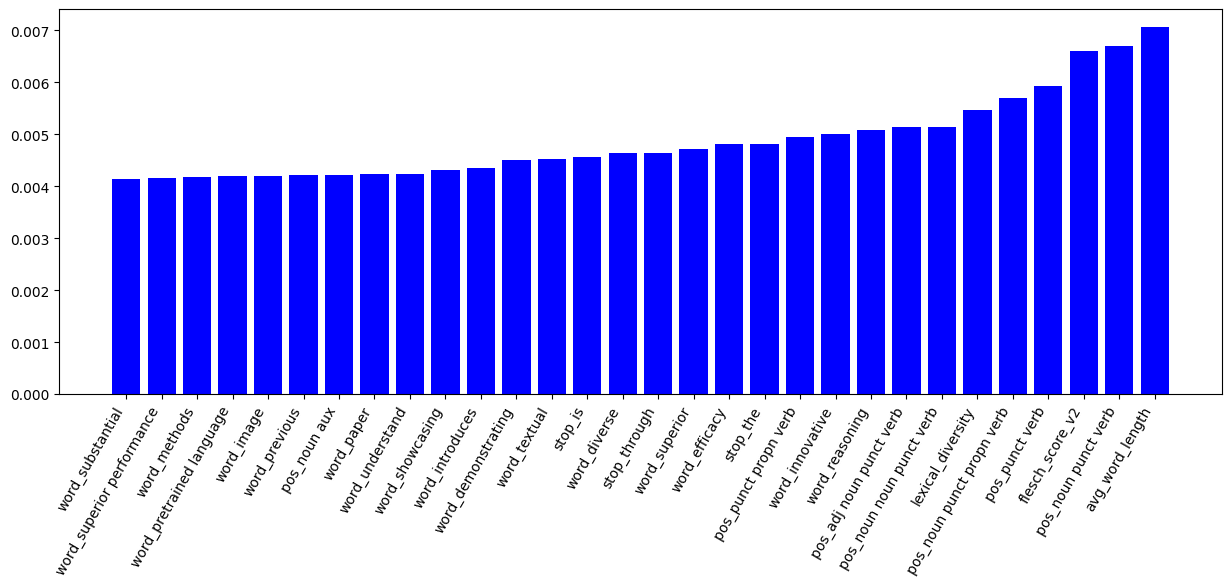

In [93]:
def plot_coefficients_LR(classifier, feature_names, top_features=30):
 coef = np.max(np.abs(classifier.coef_), axis=0).ravel()
 print (len(coef))
 top_coefficients = np.argsort(coef)[-top_features:]
 #top_negative_coefficients = np.argsort(coef)[:top_features]
 #top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 # Adjust the indices to start from zero
 plt.xticks(np.arange(top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()
 return coef[top_coefficients]

top_coef_LR = plot_coefficients_LR(LR_model, feature_names)

42855


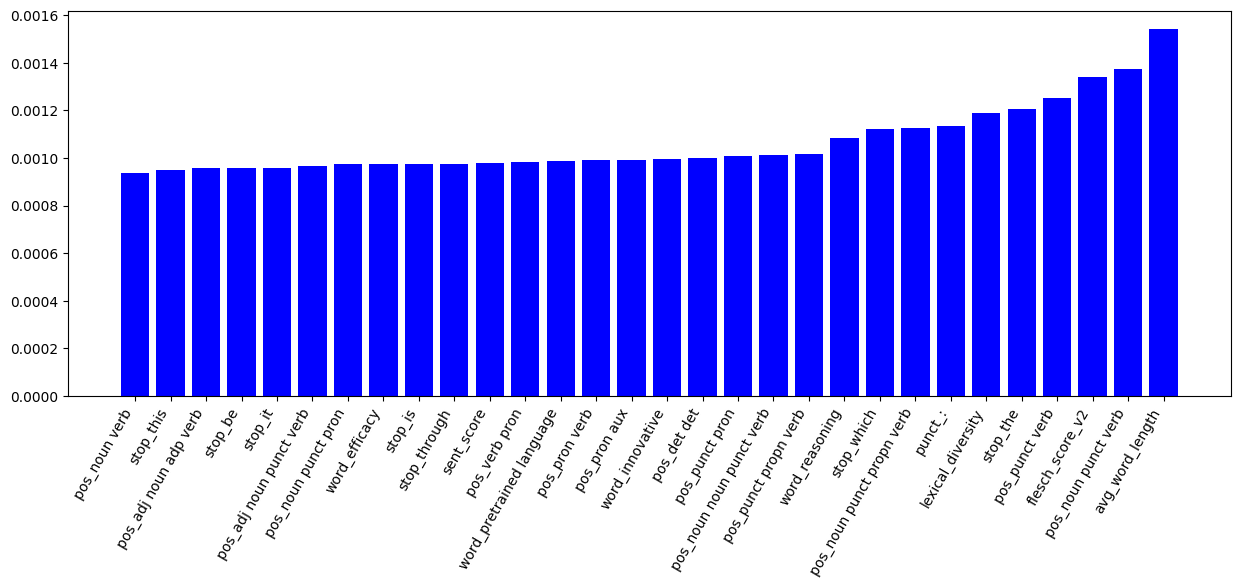

In [95]:
top_coef_SVC = plot_coefficients_LR(SVC_model, feature_names)

In [36]:
top_coef_LR

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00434291, 0.0045    , 0.00451149, 0.00455295, 0.00463044,
       0.00463836, 0.00470656, 0.00480436, 0.00481738, 0.00493678,
       0.00500082, 0.00508435, 0.005139  , 0.00513902, 0.00545855,
       0.00570262, 0.0059241 , 0.00659462, 0.00670307, 0.00705265])

In [37]:
LR_model.coef_

array([[ 0.00118774, -0.00155581, -0.00243257, ..., -0.00038422,
        -0.00038422, -0.00038422],
       [-0.00659462,  0.00403859,  0.00545855, ..., -0.00038108,
        -0.00038108, -0.00038108],
       [ 0.00201753,  0.00084697, -0.00099769, ..., -0.00029265,
        -0.00029265, -0.00029265],
       [ 0.00239199, -0.0023818 , -0.00050854, ..., -0.00033093,
        -0.00033093, -0.00033093],
       [ 0.00099735, -0.00094795, -0.00151974, ...,  0.00138889,
         0.00138889,  0.00138889]])